---
numbering: false
---

# LW1: Least-Squares Problems

{button}`Launch in Colab <https://githubtocolab.com/jflamant/mines-nancy-optimization/blob/main/labs/LW1.ipynb>`
{button}`Download .ipynb file <https://github.com/jflamant/mines-nancy-optimization/blob/main/labs/LW1.ipynb>`

In this notebook, we will explore some **least-squares problems**, one of the first fundamental optimization problems encountered in this course. We'll focus on two classical problems:
- Polynomial regression
- Denoising a signal using least-squares and *regularizers* or *penalization* methods.

This first TP involves the practical implementation of least-squares problems using two classical Python libraries:
1. **NumPy**: For efficient numerical computations, matrix operations, and solving least-squares problems using built-in linear algebra functions.
2. **Matplotlib**: For visualizing the data and displaying / interpreting results.

### Running the Notebook
This notebook can be executed in the following environments:
- **Google Colab**: A convenient, cloud-based option that requires no setup. Simply open the notebook in Colab, and you're ready to run the code.
- **Locally**: You can run the notebook on your local machine using environments like **JupyterLab** or **Jupyter Notebook**. You can also run it directly in **Visual Studio Code** if you have the Jupyter extension. In all cases, ensure you have Python installed along with the required libraries, `NumPy` and `Matplotlib`.

In [ ]:
# load necessary dependencies
import numpy as np
import matplotlib.pyplot as plt

###  1. Polynomial regression

This first exercise will permit to review basic instructions in Python as well as standard functions from NumPy and Matplotlib. The goal is to estimate the parameters of a polynomial model given experimental (i.e. noisy) data using the least-squares method.
We'll first define the *true* model, generate some noisy synthetic data, and then estimate the model parameters.

Consider the *ground truth* polynomial model $y_{\text{true}}(t) = 10t^3 + 3t^2 + 2t + 1$ for $t\in \mathbb{R}$.

**Questions**

1. Represent the function $y_{\text{true}}(t)$ on $[-1, 1]$.
2. Given $N =10$ equispaced time instants $t_1, \ldots, t_N$ over $[-1, 1]$, generate a noisy vector of measurements $\mathbf{y} \in \mathbb{R}^N$ with entries $y_n = y(t_n) = y_{\text{true}}(t) + \epsilon$, where $\epsilon \sim \mathcal{N}(0, 1)$ is Gaussian. Represent noisy measurements and the ground truth model on the same graph.
3. From the data $\mathbf{y}$, we wish to fit a polynomial model of order $d < 10$ of the form
$$y_{\text{model}}(t) = x_0 + x_1 t + x_2 t^2 + \ldots + x_{d+1}t^d$$
Write the linear model matrix $\mathbf{A}$ for an arbitrary order $d$. Construct this matrix numerically, given $d$ and the vector of time instants $\mathbf{t} = [t_1, t_2, \ldots, t_N]$. (Hint: check the ``np.vander`` function).

4. Given an integer $d <10$, write and solve the associated least squares problem. Display the estimated vector of coefficients. Compare the solution obtained by the explicit expression and that obtained with the ``np.linalg.pinv`` function.
5. Represent the estimated polynomial model for several values of $d$ (say $d=1, 3, 7$). Comment. What happens for $d=9$?
6. (Bonus) The choice of the degree of the polynomial can be evaluated using a standard criterion such as Akaike Information Criterion, defined as $\text{AIC} = 2p + 2\log r^2$, where $p$ is the number of parameters to be estimated and $r$ is the norm of the residual (in this context). Plot this criterion for the different choices of $d$. For each value of $d$ is the minimum attained?
7. (Bonus bis) Play around with differents values of $N$, true polynomial $y_{\text{true}}(t)$, or noise level $\sigma$!

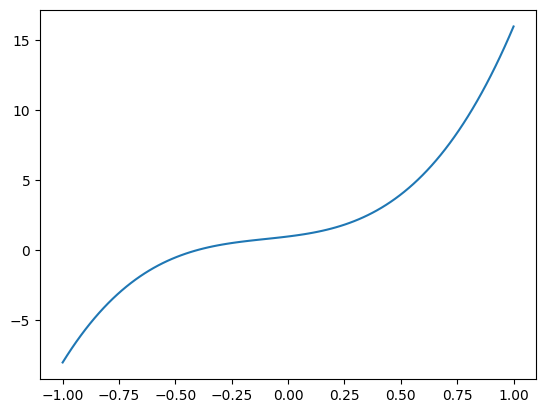

In [23]:
# question 1
def q1_y_true(t):
    return 10*t**3 + 3*t**2 + 2*t + 1
grp = np.linspace(-1,1,100)
plt.plot(grp,q1_y_true(grp))
plt.show()


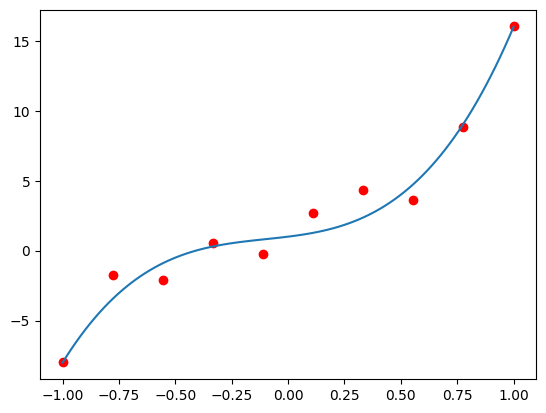

In [38]:
# question 2
t_smooth = np.linspace(-1,1,100)

t_sample = np.linspace(-1,1,10)

def q2_y_true(t):
  return 10*t**3 + 3*t**2 + 2*t + 1

noise = np.random.normal(0,1,size=10)

y_noise = q2_y_true(t_sample) + noise

plt.plot(t_smooth,q2_y_true(t_smooth))

plt.scatter(t_sample,y_noise,color = "red")

plt.show()


In [41]:
# question 3

def dsg_matrix(t,d):
  return np.vander(t,N=d+1)

t_sample = np.linspace(-1,1,10)
d=3
A = dsg_matrix(t_sample,d)
print(A.shape)


(10, 4)


In [42]:
# question 4

np.random.seed(0)               # reproducible noise
N = 10
t_samples = np.linspace(-1, 1, N)

def y_true(t):
    return 10*t**3 + 3*t**2 + 2*t + 1

# noisy measurements
noise = np.random.normal(loc=0.0, scale=1.0, size=N)
y = y_true(t_samples) + noise   # shape (N,)

# 2 Design matrix builder
def design_matrix(t, d):
    """
    returns A of shape (N, d+1) with columns [t^0, t^1, ..., t^d]
    """
    t = np.asarray(t)
    powers = np.arange(d+1)            # [0,1,...,d]
    return t[:, None] ** powers[None, :]

# 3 Set polynomial order d (d < 10)
d = 3   # change this to any integer < 10

A = design_matrix(t_samples, d)    # shape (N, d+1)

# 4 Solve by explicit normal equations
# x_normal = (A^T A)^{-1} A^T y
AtA = A.T @ A
AtY = A.T @ y

# Try inverse, if singular or ill-conditioned, fall back to pinv-based normal-solution
use_pinv_for_normal = False
try:
    # check condition number to warn/choose fallback if very ill-conditioned
    cond_AtA = np.linalg.cond(AtA)
    if cond_AtA > 1e12:
        # very ill-conditioned: avoid direct inversion
        use_pinv_for_normal = True
    if not use_pinv_for_normal:
        x_normal = np.linalg.inv(AtA) @ AtY
    else:
        # fallback
        x_normal = np.linalg.pinv(AtA) @ AtY
except np.linalg.LinAlgError:
    # fallback: pseudo-inverse
    x_normal = np.linalg.pinv(AtA) @ AtY

# 5 Solve using pseudoinverse of A
x_pinv = np.linalg.pinv(A) @ y

# 6 Compare and print
def printed_vec(name, v):
    print(f"{name} (length {v.size}):")
    np.set_printoptions(precision=8, suppress=True)
    print(v)
    print()

print("Polynomial order d =", d)
print("Design matrix A shape:", A.shape)
print()

printed_vec("x_normal (explicit normal-eq solution)", x_normal)
printed_vec("x_pinv   (pseudo-inverse solution)", x_pinv)

# Difference between the two coefficient vectors
diff = x_normal - x_pinv
print("Difference vector (x_normal - x_pinv):")
print(diff)
print("||difference||_2 =", np.linalg.norm(diff))
print()

# Residuals and norms
res_normal = y - (A @ x_normal)
res_pinv   = y - (A @ x_pinv)
print("Residual norm ||y - A x_normal||_2 =", np.linalg.norm(res_normal))
print("Residual norm ||y - A x_pinv||_2   =", np.linalg.norm(res_pinv))
print()

Polynomial order d = 3
Design matrix A shape: (10, 4)

x_normal (explicit normal-eq solution) (length 4):
[ 1.74801268  0.41597906  2.9754803  11.13124773]

x_pinv   (pseudo-inverse solution) (length 4):
[ 1.74801268  0.41597906  2.9754803  11.13124773]

Difference vector (x_normal - x_pinv):
[-0. -0.  0.  0.]
||difference||_2 = 4.733522806338002e-14

Residual norm ||y - A x_normal||_2 = 2.547068036228569
Residual norm ||y - A x_pinv||_2   = 2.5470680362285685



In [ ]:
# question 5:




In [ ]:
# question 6: Bonus

### 2. Denoising

This second problem is the *denoising* problem which corresponds to the reconstruction of a signal $x(t)$ from noisy measurements $y(t) = x(t) + n(t)$, where $n(t)$ is some noise.
A typical assumption is that noise is Gaussian, i.e., for a given time instant $t_i$,  $n(t_i) \sim \mathcal{N}(0, \sigma^2)$ where $\sigma^2$ is the noise variance.

The denoising problem can be formulated as a least squares problem. Let $t_1, \ldots, t_N$ be $N$ time instants and denote by $\mathbf{x}, \mathbf{y}$ the vectors encoding the signal and the measurements, respectively. The denoising problem seeks to solve

$$\min_{\mathbf{x}\in\mathbb{R}^N} \Vert \mathbf{y}-\mathbf{x}\Vert^2_2$$

**Preliminary questions**
1. What is the solution to the least squares problem $\hat{\mathbf{x}}$?

Usually, we have access to extra information about the signal $\mathbf{x}$: e.g. it is non-negative, it belongs to some class of constraints, it exhibits regularity in some representation domain, etc.
A classical assumption is that the signal is smooth. At first order, this is encoded by the function
$$ r(\mathbf{x}) = \sum_{n=1}^{N-1} (x_{n+1}- x_{n})^2$$

2. Show that $r(\mathbf{x}) $ can be expressed as $r(\mathbf{x}) = \Vert \mathbf{D}_1\mathbf{x}\Vert^2_2$

To take into account the smoothness of the solution into the denoising problem, we formulate a new problem, called *regularized least squares* or *penalized least squares*. It reads
$$\min_{\mathbf{x}\in \mathbb{R}^N} \Vert \mathbf{y} - \mathbf{x}\Vert^2_2 + \lambda r(\mathbf{x}), \quad \lambda \geq 0$$
where
- $\Vert \mathbf{y}-\mathbf{x}\Vert$ is called the data fidelity term;
- $r(\mathbf{x})$ is the regularization (or penalty) and $\lambda\geq 0$ is called the regularization parameter.

3. Compute the solution to the regularized least squares problem above with $r(\mathbf{x}) = \Vert \mathbf{D}_1\mathbf{x}\Vert^2_2$. Comment on the uniqueness of the solution. What happens when $\lambda \rightarrow 0$? When $\lambda \rightarrow \infty$?

> Write here your answers to preliminary questions using Markdown

**Implementation tasks**

1. Generate a smooth signal $x(t) = \cos(2\pi f_0 t)$ where $f_0 = 5$ Hz and $t \in [0, 1]$ s. Choose a sampling frequency that satisfies the Shannon-Nyquist criterion.
2. Generate noisy measurements by corrupting the signal vector $\mathbf{x}$ by additive white Gaussian noise with SNR = 10 dB. (Recall the formula for the SNR!)
3. Solve the regularized least squares for different values of $\lambda$, and represent corresponding solutions. Compare it to the ground truth signal.  
4. A common question in penalized optimization problems is to choose the hyperparameter $\lambda$. A classical approach is to use a heuristic called L-curve: for various values of $\lambda$, plot the data fidelity term vs the penalty term in the cost function. From this tool, what would be a good choice of $\lambda$ according to you? Why?
5. Start again the exercise with the second-order penalty function
$$ r(\mathbf{x}) = \sum_{n=2}^{N-1} (x_{n+1}- 2x_{n} + x_{n-1})^2$$
Compare your results with the first-order difference penalty.

In [ ]:
# question 1.

In [ ]:
# Question 2:

In [ ]:
# question 3:

In [ ]:
# question 4


In [ ]:
# question 5